In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/"

Mounted at /content/drive


In [2]:
# import packages

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from math import ceil
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf

In [3]:
# load data with shuffle and non-shuffle flows
# Final train note: adjust file path and batch size as needed

batch_size = 32

# fn for scaling data -1 to 1 while still using ImageDataGenerator

def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

data = ImageDataGenerator(preprocessing_function=prep_fn,
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=45, 
                          validation_split=0.2)

training_data = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                         target_size=(299, 299), shuffle=True, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

training_data_noshuffle = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                         target_size=(299, 299), shuffle=False, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

test_data = data.flow_from_directory('/content/drive/My Drive/archive/images/Images', 
                                     target_size=(299, 299), batch_size = batch_size, shuffle=False,
                                     class_mode='categorical', subset='validation')

numClasses = 120

Found 16604 images belonging to 120 classes.
Found 16604 images belonging to 120 classes.
Found 4096 images belonging to 120 classes.


In [4]:
import time
start_time = time.time()

In [5]:
# model architecture

cnn = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
cnn.trainable = False

flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = Dense(1024, activation='relu')
dense_layer_2 = Dense(786, activation='relu')
dense_layer_3 = Dense(345, activation='relu')
prediction_layer = Dense(120, activation='softmax')

Classifier = Sequential([
    cnn,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

83683744/83683744 [==============================] - 1s 0us/step


In [6]:
# compile and train
# Final train note: adjust MyEpochs to match homebrew CNNs, can adjust batch size as well if needed

MyEpochs = 50
opt = keras.optimizers.Adam()

Classifier.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt, 
              metrics=['accuracy']) 

Classifier.fit(training_data,
                        batch_size = 32,
                        epochs = MyEpochs,
                        validation_data=test_data,
                        shuffle = 1)

Epoch 1/50
519/519 [==============================] - 4335s 8s/step - loss: 2.0681 - accuracy: 0.6144 - val_loss: 1.1142 - val_accuracy: 0.7029
Epoch 2/50
519/519 [==============================] - 448s 863ms/step - loss: 1.0023 - accuracy: 0.7381 - val_loss: 1.0386 - val_accuracy: 0.7322
Epoch 3/50
519/519 [==============================] - 445s 857ms/step - loss: 0.8589 - accuracy: 0.7691 - val_loss: 1.0361 - val_accuracy: 0.7319
Epoch 4/50
519/519 [==============================] - 446s 860ms/step - loss: 0.7775 - accuracy: 0.7888 - val_loss: 0.9537 - val_accuracy: 0.7522
Epoch 5/50
519/519 [==============================] - 446s 859ms/step - loss: 0.7034 - accuracy: 0.8055 - val_loss: 0.9884 - val_accuracy: 0.7544
Epoch 6/50
519/519 [==============================] - 446s 860ms/step - loss: 0.7009 - accuracy: 0.8062 - val_loss: 1.0272 - val_accuracy: 0.7410
Epoch 7/50
519/519 [==============================] - 444s 856ms/step - loss: 0.6856 - accuracy: 0.8121 - val_loss: 0.9757 - v

In [7]:
# architecture of layers

Classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 1024)              209716224 
                                                                 
 dense_1 (Dense)             (None, 786)               805650    
                                                                 
 dense_2 (Dense)             (None, 345)               271515    
                                                                 
 dense_3 (Dense)             (None, 120)               41520     
                                                                 
Total params: 231,696,389
Trainable params: 210,834,909


In [8]:
# fine tuning
# Final train note: don't adjust any of these hyperparameters, keep as-is

cnn.trainable = True

Classifier.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.categorical_crossentropy,
    metrics=['Accuracy'],
)

MyEpochs = 10
Classifier.fit(training_data,
                        batch_size = 10,
                        epochs = MyEpochs,
                        validation_data=test_data,
                        shuffle = 1)

Classifier.save('Xception.h5')

Epoch 1/10
519/519 [==============================] - 484s 870ms/step - loss: 0.8110 - Accuracy: 0.8649 - val_loss: 1.8879 - val_Accuracy: 0.7651
Epoch 2/10
519/519 [==============================] - 444s 856ms/step - loss: 0.4242 - Accuracy: 0.9100 - val_loss: 1.6123 - val_Accuracy: 0.7769
Epoch 3/10
519/519 [==============================] - 443s 854ms/step - loss: 0.3363 - Accuracy: 0.9210 - val_loss: 1.5007 - val_Accuracy: 0.7869
Epoch 4/10
519/519 [==============================] - 442s 852ms/step - loss: 0.2902 - Accuracy: 0.9279 - val_loss: 1.4103 - val_Accuracy: 0.7864
Epoch 5/10
519/519 [==============================] - 443s 854ms/step - loss: 0.2745 - Accuracy: 0.9349 - val_loss: 1.3404 - val_Accuracy: 0.7883
Epoch 6/10
519/519 [==============================] - 447s 861ms/step - loss: 0.2386 - Accuracy: 0.9433 - val_loss: 1.4268 - val_Accuracy: 0.7913
Epoch 7/10
519/519 [==============================] - 447s 862ms/step - loss: 0.2328 - Accuracy: 0.9458 - val_loss: 1.3854 -

In [9]:
# model evaluation

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# confusion matrix, accuracy, classification report 

training_data.reset()
test_data.reset()

predicted_scores = Classifier.predict(test_data, verbose=1)
predicted_labels = predicted_scores.argmax(axis=1) 

test_labels = test_data.labels

print(test_labels)
print(predicted_labels)

acc_score = accuracy_score(test_labels, predicted_labels)
CFM = confusion_matrix(test_labels, predicted_labels)

print("\n", "Accuracy: " + str(format(acc_score,'.3f')))
print("\n", "CFM: \n", confusion_matrix(test_labels, predicted_labels))
print("\n", "Classification report: \n", classification_report(test_labels, predicted_labels))

128/128 [==============================] - 90s 694ms/step
[  0   0   0 ... 119 119 119]
[  0   0   0 ... 119 119 119]

 Accuracy: 0.805

 CFM: 
 [[23  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 43 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  1  0]
 [ 0  0  0 ...  0 27  0]
 [ 0  0  0 ...  0  0 32]]

 Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.77      0.74        30
           1       0.81      0.95      0.88        37
           2       0.83      0.86      0.84        50
           3       0.81      0.72      0.76        29
           4       0.67      0.76      0.71        42
           5       0.89      0.89      0.89        37
           6       0.94      0.85      0.89        39
           7       0.80      0.82      0.81        34
           8       0.75      0.62      0.68        34
           9       0.94      0.98      0.96        47
          10       0.79      0.89      0.84        35
          11       0.76

# Visualizations

In [10]:
# Visual Specific Imports
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    auc, 
    roc_curve,
    roc_auc_score,
)


ROC AUC score: 0.9


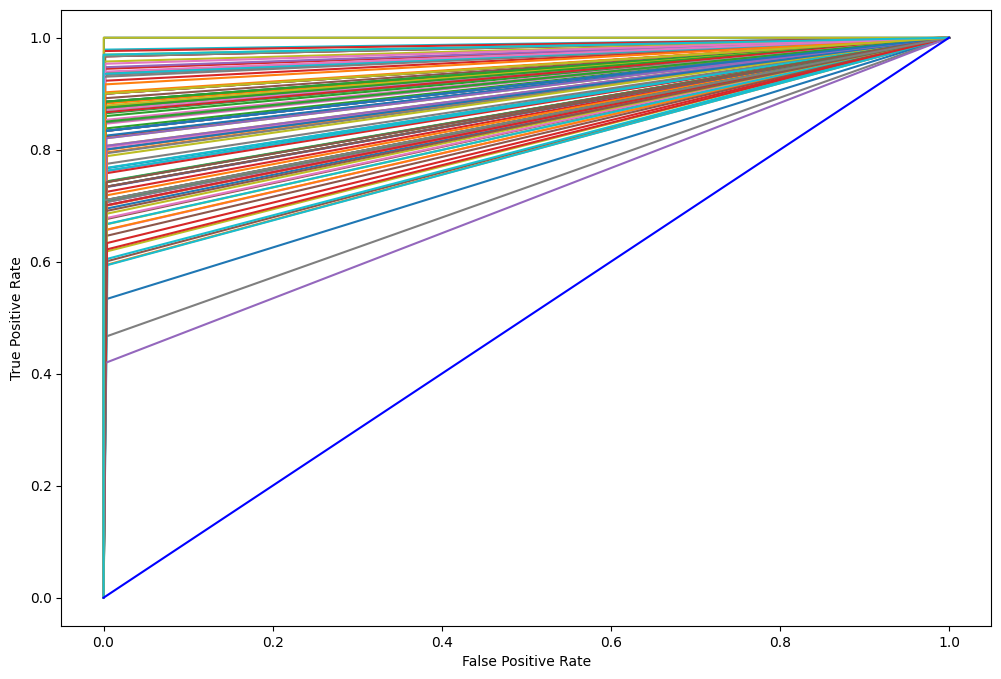

In [11]:
# add visualization here
target = list(test_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    auc_list = []
    auc_results_dict = {}

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        
        auc_list += [auc(fpr, tpr)]

    # Create auc_results_df
    auc_results_dict['Breed'] = target
    auc_results_dict['AUC'] = auc_list
    index = range(len(auc_results_dict['Breed']))
    auc_results_df = pd.DataFrame(auc_results_dict, index=index)

    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

    return roc_auc_score(y_test, y_pred, average=average), auc_results_df


# Set parameters here
roc_auc_score_result, auc_results_df = multiclass_roc_auc_score(test_labels, predicted_labels)
print('ROC AUC score:', round(roc_auc_score_result,2))

# c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [12]:
classification_report_dict = classification_report(test_labels, predicted_labels, output_dict=True)

macro_avgs = {}
for i in range(3):
    key, value = classification_report_dict.popitem()
    macro_avgs[key] = value

index = range(len(classification_report_dict))
classification_report_df = pd.DataFrame(classification_report_dict).T
classification_report_df.index = classification_report_df.index.astype('int64')

class_results_df = auc_results_df.join(classification_report_df).sort_values('f1-score', ascending=False)

In [13]:
df_macro_avgs = pd.DataFrame(macro_avgs).T.iloc[:2, :3]
print('Averages:')
display(round(df_macro_avgs,2))

Averages:


precision  recall  f1-score
weighted avg       0.81     0.8       0.8
macro avg          0.81     0.8       0.8

Top and Bottom 5 by AUC

In [14]:
print('Top 5 by AUC')
display(class_results_df.sort_values('AUC', ascending=False).head(5))
print('\n\nBottom 5 by AUC')
display(class_results_df.sort_values('AUC', ascending=True).head(5))

Top 5 by AUC


Breed       AUC  precision    recall  f1-score  \
108                 n02112137-chow  0.999877   0.975000  1.000000  0.987342   
30    n02093647-Bedlington_terrier  0.999754   0.947368  1.000000  0.972973   
9           n02088094-Afghan_hound  0.988991   0.938776  0.978723  0.958333   
103             n02111129-Leonberg  0.987849   0.953488  0.976190  0.964706   
119  n02116738-African_hunting_dog  0.984848   1.000000  0.969697  0.984615   

     support  
108     39.0  
30      36.0  
9       47.0  
103     42.0  
119     33.0



Bottom 5 by AUC


Breed       AUC  precision    recall  \
114                n02113712-miniature_poodle  0.708570   0.590909  0.419355   
97                       n02109961-Eskimo_dog  0.731612   0.500000  0.466667   
80                           n02106030-collie  0.764945   0.533333  0.533333   
29   n02093428-American_Staffordshire_terrier  0.794906   0.542857  0.593750   
21                          n02091134-whippet  0.795326   0.578947  0.594595   

     f1-score  support  
114  0.490566     31.0  
97   0.482759     30.0  
80   0.533333     30.0  
29   0.567164     32.0  
21   0.586667     37.0

Top and Bottom 5 by F1-Score

In [15]:
print('Top 5 by F1-Score')
display(class_results_df.sort_values('f1-score', ascending=False).head(5))
print('\n\nBottom 5 by F1-Score')
display(class_results_df.sort_values('f1-score', ascending=True).head(5))

Top 5 by F1-Score


Breed       AUC  precision    recall  f1-score  \
108                 n02112137-chow  0.999877   0.975000  1.000000  0.987342   
119  n02116738-African_hunting_dog  0.984848   1.000000  0.969697  0.984615   
30    n02093647-Bedlington_terrier  0.999754   0.947368  1.000000  0.972973   
73           n02105056-groenendael  0.983210   0.966667  0.966667  0.966667   
103             n02111129-Leonberg  0.987849   0.953488  0.976190  0.964706   

     support  
108     39.0  
119     33.0  
30      36.0  
73      30.0  
103     42.0



Bottom 5 by F1-Score


Breed       AUC  precision    recall  \
97                       n02109961-Eskimo_dog  0.731612   0.500000  0.466667   
114                n02113712-miniature_poodle  0.708570   0.590909  0.419355   
80                           n02106030-collie  0.764945   0.533333  0.533333   
29   n02093428-American_Staffordshire_terrier  0.794906   0.542857  0.593750   
99                   n02110185-Siberian_husky  0.800291   0.547619  0.605263   

     f1-score  support  
97   0.482759     30.0  
114  0.490566     31.0  
80   0.533333     30.0  
29   0.567164     32.0  
99   0.575000     38.0

In [16]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 34164.06 seconds
